Performance analysis concentrating on understanding the current state of the Largest Contentful Paint (LCP) metric.

Experimental data was collected between (2024-01-26 to 2024-02-06), on a frameworks laptop (13) on  wireless connection in SF. The Chrome (121.0.6167.160) and Firefox browsers (nightly as of 20240124) were hosted on Linux, the browsertime testing framework was used in combination with [sitelists generated](https://https://sunglint.wordpress.com/2024/01/23/origin-url-top-list/) from CrUX.

[Data results objects archive](https://https://drive.google.com/drive/folders/1L9BBLu566WAsjAI0w4gVGGzSFSU1ALg3?usp=drive_link) on Google Drive in the form of compressed browsertime-results directory with JSON and mp4 outputs.

[Data results transformed into CSV](https://github.com/bdekoz/mozilla-data-lcp).



In [ ]:
#@title setup, static and constant data

from google.cloud import bigquery
from datetime import datetime, timedelta
from re import sub
from os import path
from google.colab import auth
auth.authenticate_user()


# use interactive tables
from google.colab import data_table
data_table.enable_dataframe_formatter()


import datetime
import time
import hashlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from scipy.stats import ttest_ind
from scipy.stats import ks_2samp
from scipy.stats import mannwhitneyu

#pd.set_option('display.width', 180)


# useful constants
tab = "\t";
newline = "\n";

In [ ]:
#@title percentage(numerator, denom)

def percentage(part, whole):
  Percentage = 100 * float(part)/float(whole)
  return str(int(round(Percentage,0))) + '%'

In [ ]:
#@title load csv data from github


#import from github csv as per links above, select csv and look at raw url
# CSV is formatted in this order, with '|' as a delimiter
# url-id, url, fetchStart, connectStart, responseStart, SpeedIndex, VC85, fcp, lcp-load, lcp-render, lcp-element

# data file location
data_prefix ='https://raw.githubusercontent.com/bdekoz/mozilla-data-lcp/main/'

# csv data files
# workstation = 1920x1536
# laptop = 1366x768
# mobile-p = mobile portrait = 360x800
# mobile-l = mobile landscape = 800x360

# global 1k results
d1k_cworkstation = data_prefix + 'crux-global-10M-1k/1920x1536/chrome-consolidated.lcp.csv'
d1k_fworkstation = data_prefix + 'crux-global-10M-1k/1920x1536/firefox-consolidated.lcp.csv'

# global 200 results
d200_cworkstation = data_prefix + 'crux-global-10M-200/1920x1536/chrome-consolidated.lcp.csv'
d200_fworkstation = data_prefix + 'crux-global-10M-200/1920x1536/firefox-consolidated.lcp.csv'

d200_claptop = data_prefix + 'crux-global-10M-200/1366x768/chrome-consolidated.lcp.csv'
d200_flaptop = data_prefix + 'crux-global-10M-200/1366x768/firefox-consolidated.lcp.csv'

d200_cmobilep = data_prefix + 'crux-global-10M-200/360x800/chrome-consolidated.lcp.csv'
d200_fmobilep = data_prefix + 'crux-global-10M-200/360x800/firefox-consolidated.lcp.csv'

d200_cmobilel = data_prefix + 'crux-global-10M-200/800x360/chrome-consolidated.lcp.csv'
d200_fmobilel = data_prefix + 'crux-global-10M-200/800x360/firefox-consolidated.lcp.csv'


df1 = pd.read_csv(d200_cworkstation, sep='|');
df1.set_index(df1.columns[0]) #set the first column as the index
df1_len = len(df1.index)


df2 = pd.read_csv(d200_fworkstation, sep='|');
df2.set_index(df2.columns[0]) #set the first column as the index
df2_len = len(df2.index)

# error check data frames
if df1_len != df2_len:
  print("Exiting, dataframes have different indexes");


# print data frames
#df1
#df2

#df2.plot()

#dfbool = df2.columns[lcp-element] != df1.columns[lcp-element];
dflcpeb = df2["lcp-element"] == df1["lcp-element"];
lcpe_same = dflcpeb.sum();

lcpmatch = percentage(lcpe_same, df1_len);

print("LCP element match grid")
print("Firefox matches Chrome for " + lcpmatch + ", " + str(lcpe_same) + " urls.");

LCP element match grid
Firefox matches Chrome for 31%, 47 urls.


In [ ]:
#@title compare_2_lcp_elements / compare_4_lcp_elements


#import from github csv as per links above, select csv and look at raw url
# CSV is formatted in this order, with '|' as a delimiter
# url-id, url, fetchStart, connectStart, responseStart, SpeedIndex, VC85, fcp, lcp-load, lcp-render, lcp-element

# data file location
data_prefix ='https://raw.githubusercontent.com/bdekoz/mozilla-data-lcp/main/'

# csv data files
# workstation = 1920x1536
# laptop = 1366x768
# mobile-p = mobile portrait = 360x800
# mobile-l = mobile landscape = 800x360

# global 1k results
d1k_cworkstation = data_prefix + 'crux-global-10M-1k/1920x1536/chrome-consolidated.lcp.csv'
d1k_fworkstation = data_prefix + 'crux-global-10M-1k/1920x1536/firefox-consolidated.lcp.csv'

# global 200 results
d200_cworkstation = data_prefix + 'crux-global-10M-200/1920x1536/chrome-consolidated.lcp.csv'
d200_fworkstation = data_prefix + 'crux-global-10M-200/1920x1536/firefox-consolidated.lcp.csv'

d200_claptop = data_prefix + 'crux-global-10M-200/1366x768/chrome-consolidated.lcp.csv'
d200_flaptop = data_prefix + 'crux-global-10M-200/1366x768/firefox-consolidated.lcp.csv'

d200_cmobilep = data_prefix + 'crux-global-10M-200/360x800/chrome-consolidated.lcp.csv'
d200_fmobilep = data_prefix + 'crux-global-10M-200/360x800/firefox-consolidated.lcp.csv'

d200_cmobilel = data_prefix + 'crux-global-10M-200/800x360/chrome-consolidated.lcp.csv'
d200_fmobilel = data_prefix + 'crux-global-10M-200/800x360/firefox-consolidated.lcp.csv'


# Compare two data files for LCP element matching
def compare_2_lcp_elements(fone, ftwo):
  df1 = pd.read_csv(fone, sep='|');
  df1.set_index(df1.columns[0]) #set the first column as the index
  df1_len = len(df1.index)

  df2 = pd.read_csv(ftwo, sep='|');
  df2.set_index(df2.columns[0]) #set the first column as the index
  df2_len = len(df2.index)

  # error check data frames
  if df1_len != df2_len:
    print("Exiting, dataframes have different indexes");

  #dfbool = df2.columns[lcp-element] != df1.columns[lcp-element];
  dflcpe = df2["lcp-element"] == df1["lcp-element"];
  lcpe_same = dflcpe.sum();

  lcpmatch = percentage(lcpe_same, df1_len);
  return lcpmatch;

# Compare four data files for LCP element matching
def compare_4_lcp_elements(f1, f2, f3, f4):
  df1 = pd.read_csv(f1, sep='|');
  df1.set_index(df1.columns[0]) #set the first column as the index
  df1_len = len(df1.index)

  df2 = pd.read_csv(f2, sep='|');
  df2.set_index(df2.columns[0]) #set the first column as the index
  df2_len = len(df2.index)

  df3 = pd.read_csv(f3, sep='|');
  df3.set_index(df3.columns[0]) #set the first column as the index
  df3_len = len(df3.index)

  df4 = pd.read_csv(f4, sep='|');
  df4.set_index(df4.columns[0]) #set the first column as the index
  df4_len = len(df4.index)

  # error check data frames
  if df1_len != df2_len != df3_len != df4_len:
    print("Exiting, dataframes have different indexes");

  dflcpe1 = df1["lcp-element"] == df2["lcp-element"];
  dflcpe2 = df3["lcp-element"] == df4["lcp-element"];
  dflcpe = dflcpe1 & dflcpe2;
  lcpe_same = dflcpe.sum();

  lcpmatch = percentage(lcpe_same, df1_len);
  return lcpmatch;



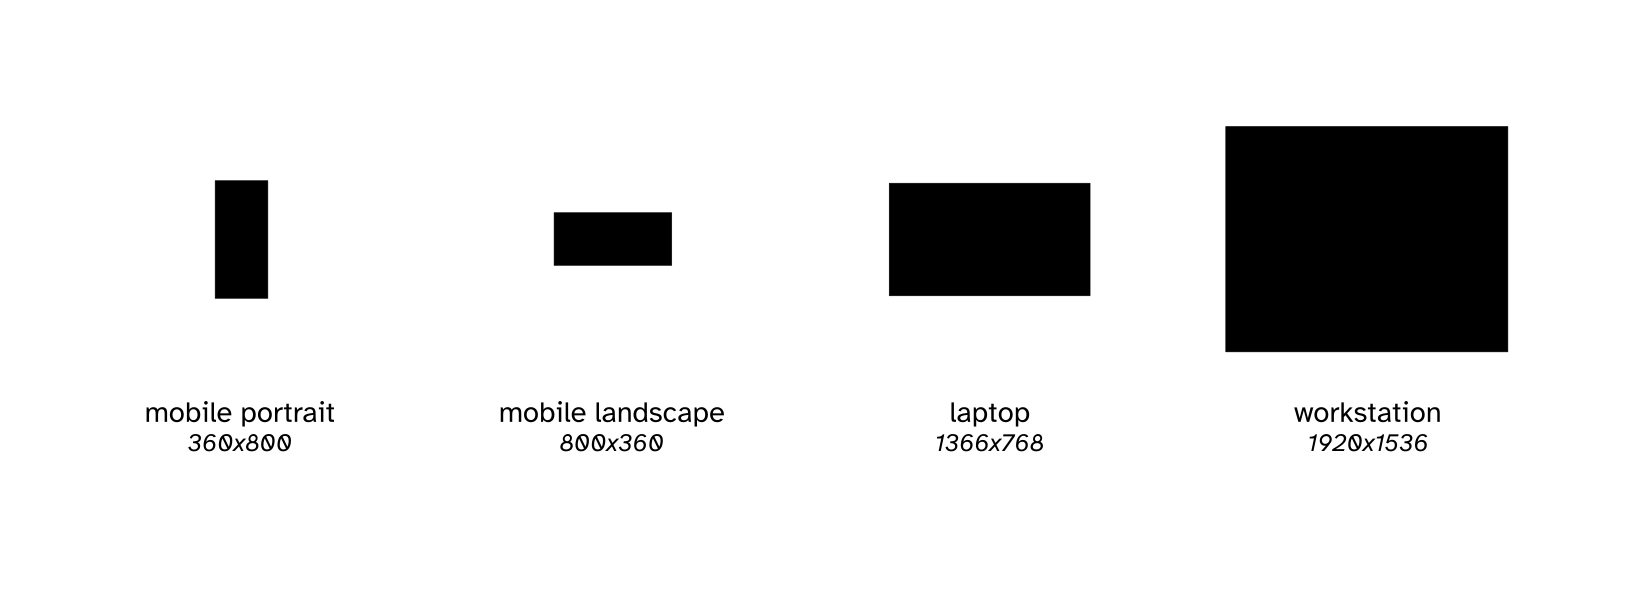

firefox x firefox compares by viewport size

In [ ]:
print("firefox x firefox (baseline mobile portrait)")

ffm = compare_2_lcp_elements(d200_fmobilep, d200_fmobilel);
print("mobile portrait to mobile landscape: " + ffm);

fflap = compare_2_lcp_elements(d200_fmobilep, d200_flaptop);
print("mobile portrait to laptop: " + fflap);

ffwork = compare_2_lcp_elements(d200_fmobilep, d200_fworkstation);
print("mobile portrait to workstation: " + ffwork);


In [ ]:
print("firefox x firefox (baseline mobile landscape)")

ffm = compare_2_lcp_elements(d200_fmobilel, d200_fmobilep);
print("mobile landscape to mobile portrait: " + ffm);

fflap = compare_2_lcp_elements(d200_fmobilel, d200_flaptop);
print("mobile landscape to laptop: " + fflap);

ffwork = compare_2_lcp_elements(d200_fmobilel, d200_fworkstation);
print("mobile landscape to workstation: " + ffwork);


In [ ]:
ff4 = compare_4_lcp_elements(d200_fmobilel, d200_fmobilep, d200_flaptop, d200_fworkstation);
print("firefox 4 way: " + ff4);


chrome x chrome compares by viewport size

In [ ]:
print("chrome x chrome (baseline mobile portrait)")

ffm = compare_2_lcp_elements(d200_cmobilep, d200_cmobilel);
print("mobile portrait to mobile landscape: " + ffm);

fflap = compare_2_lcp_elements(d200_cmobilep, d200_claptop);
print("mobile portrait to laptop: " + fflap);

ffwork = compare_2_lcp_elements(d200_cmobilep, d200_cworkstation);
print("mobile portrait to workstation: " + ffwork);


In [ ]:
print("chrome x chrome (baseline mobile landscape)")

ffm = compare_2_lcp_elements(d200_cmobilel, d200_cmobilep);
print("mobile landscape to mobile portrait: " + ffm);

fflap = compare_2_lcp_elements(d200_cmobilel, d200_claptop);
print("mobile landscape to laptop: " + fflap);

ffwork = compare_2_lcp_elements(d200_cmobilel, d200_cworkstation);
print("mobile landscape to workstation: " + ffwork);


In [ ]:
c4 = compare_4_lcp_elements(d200_cmobilel, d200_cmobilep, d200_claptop, d200_cworkstation);
print("chrome 4 way: " + c4);


firefox/chrome compare by size

In [ ]:
fcmp = compare_2_lcp_elements(d200_fmobilep, d200_cmobilep);
print("ff/chrome mobile p: " + fcmp);

fcml = compare_2_lcp_elements(d200_fmobilel, d200_cmobilel);
print("ff/chrome mobile l: " + fcml);

fclap = compare_2_lcp_elements(d200_flaptop, d200_claptop);
print("ff/chrome laptop: " + fclap);

fcwork = compare_2_lcp_elements(d200_fworkstation, d200_cworkstation);
print("ff/chrome workstation: " + fcwork);

ff/chrome mobile p: 29%
ff/chrome mobile l: 30%
ff/chrome laptop: 32%
ff/chrome workstation: 31%


correlations with other metrics

In [9]:
dflcprf = df2["lcp-render"]
dfsif = df2["SpeedIndex"]

#dflcprf.plot()
#dfsif.plot()

corrsif = dflcprf.corr(df2['SpeedIndex'], method='pearson');
print(corrsif)


# Correlation between all the columns of DataFrame.
dfsumf=df2.corr();
print(dfsumf);

0.980527198711302
               fetchStart  connectStart  responseStart  SpeedIndex      VC85  \
fetchStart       1.000000      0.022884       0.022950    0.008277  0.001639   
connectStart     0.022884      1.000000       0.992726    0.955089  0.921503   
responseStart    0.022950      0.992726       1.000000    0.966765  0.934521   
SpeedIndex       0.008277      0.955089       0.966765    1.000000  0.986776   
VC85             0.001639      0.921503       0.934521    0.986776  1.000000   
fcp              0.022783      0.980322       0.989656    0.981224  0.951537   
lcp-load         0.006318      0.951213       0.963814    0.968737  0.949911   
lcp-render       0.009057      0.957271       0.970255    0.980527  0.961063   

                    fcp  lcp-load  lcp-render  
fetchStart     0.022783  0.006318    0.009057  
connectStart   0.980322  0.951213    0.957271  
responseStart  0.989656  0.963814    0.970255  
SpeedIndex     0.981224  0.968737    0.980527  
VC85           0.9515

<ipython-input-9-d07f67773533>:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dfsumf=df2.corr();


In [10]:
dflcprc = df1["lcp-render"]
dfsic = df1["SpeedIndex"]

#dflcpr.plot()
#dfsi.plot()

corrsic = dflcprc.corr(df1['SpeedIndex'], method='pearson');
print(corrsic)


# Correlation between all the columns of DataFrame.
dfsumc=df1.corr();
print(dfsumc);

0.8370398548433668
               fetchStart  connectStart  responseStart  SpeedIndex      VC85  \
fetchStart       1.000000      0.807076       0.688686    0.481713  0.448514   
connectStart     0.807076      1.000000       0.916360    0.540281  0.480855   
responseStart    0.688686      0.916360       1.000000    0.638018  0.584134   
SpeedIndex       0.481713      0.540281       0.638018    1.000000  0.967087   
VC85             0.448514      0.480855       0.584134    0.967087  1.000000   
fcp              0.571137      0.722044       0.838178    0.824587  0.779986   
lcp-load         0.430199      0.570152       0.667457    0.745846  0.735019   
lcp-render       0.510619      0.618136       0.725474    0.837040  0.832418   

                    fcp  lcp-load  lcp-render  
fetchStart     0.571137  0.430199    0.510619  
connectStart   0.722044  0.570152    0.618136  
responseStart  0.838178  0.667457    0.725474  
SpeedIndex     0.824587  0.745846    0.837040  
VC85           0.779

<ipython-input-10-d84c7c511d0e>:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dfsumc=df1.corr();


baseline numeric compare firefox/chrome


In [ ]:
#@title percentage_change

def percentage_change(col1, col2):
    return ((col2 - col1) / col1) * 100

dfpchange = percentage_change(df1["lcp-render"], df2["lcp-render"])

print(dfpchange.min())
print(dfpchange.max())
print(dfpchange.median())

#print(dfpchange);
#dfpchange.plot();

-83.7393846582208
13437.518463810931
5.9679767103347885


In [ ]:
#@title compare_similar_elements_by_setaside


df = pd.DataFrame(columns=['value'], index=range(df1_len))

for i in range(df1_len):
  if dflcpeb.iloc[i] == True:
    vc = df1['lcp-render'].iloc[i];
    vf = df2['lcp-render'].iloc[i];
    pc = percentage_change(vc, vf);
    df.iloc[i] = pc;
    print(i, vc, vf);
    print(str(pc) + '%')
    print(newline)


6 2748.0 2912.0
5.9679767103347885%


11 936.0 475.0
-49.25213675213676%


14 953.0 1197.0
25.603357817418676%


16 1155.0 2774.0
140.17316017316017%


22 3608.0 3153.0
-12.610864745011085%


35 5307.0 5508.0
3.7874505370265688%


37 541.0 776.0
43.438077634011094%


40 3569.0 3824.0
7.144858503782572%


44 2134.0 782.0
-63.3552014995314%


47 253.0 324.0
28.063241106719367%


48 3294.0 3838.0
16.514875531268974%


51 3105.0 2508.0
-19.22705314009662%


52 3287.0 3607.0
9.735320961362945%


53 3134.0 690.0
-77.98340778557754%


54 3937.0 2531.0
-35.71247142494285%


56 4898.0 6928.0
41.445487954267044%


58 427.0 312.0
-26.93208430913349%


61 673.0 794.0
17.97919762258544%


65 11055.0 5406.0
-51.09905020352782%


73 10811.0 13155.0
21.681620571639996%


74 396.0 394.0
-0.5050505050505051%


78 1203.0 1002.0
-16.708229426433917%


80 196.0 199.0
1.530612244897959%


82 1644.0 1537.0
-6.5085158150851585%


84 2584.0 1242.0
-51.93498452012384%


87 2847.0 3883.0
36.389181594661046%


88